**1)** Get all of the code in the blog working, and train a 2 layer RNN as shown

**Data Preparation**

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.9 MB/s eta 0:00:00


In [3]:
import os
import random
from string import ascii_letters
import torch
from torch import nn
import torch.nn.functional as F
from unidecode import unidecode
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

_ = torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!curl -O https://download.pytorch.org/tutorial/data.zip; unzip data.zip
# Download and unzip the files into the current directory, under the folder name of data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  21.1M      0 --:--:-- --:--:-- --:--:-- 21.1M
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

In [ ]:
data_dir = "./data/names"

# dictionary that maps a language to a numerical label.
lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}
print(lang2label)
num_langs = len(lang2label)  # Stor number of languages

{'Irish': tensor([0]), 'Polish': tensor([1]), 'English': tensor([2]), 'Scottish': tensor([3]), 'Korean': tensor([4]), 'Czech': tensor([5]), 'Italian': tensor([6]), 'Japanese': tensor([7]), 'Chinese': tensor([8]), 'Dutch': tensor([9]), 'Greek': tensor([10]), 'French': tensor([11]), 'German': tensor([12]), 'Arabic': tensor([13]), 'Spanish': tensor([14]), 'Portuguese': tensor([15]), 'Vietnamese': tensor([16]), 'Russian': tensor([17])}


**Pre-Processing**

In [ ]:
unidecode("Ślusàrski")  # Want to use unicode to normalize all the data (this is an example)

'Slusarski'

In [ ]:
# Map characters to numbers
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}
num_letters = len(char2idx); num_letters

59

In [ ]:
def name2tensor(name):  # Map each name to a tensor of numbers
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, char in enumerate(name):
        tensor[i][0][char2idx[char]] = 1  # Output size is (num_char, 1, 59)
    return tensor

In [ ]:
name2tensor("abc") # Dummy input for testing

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

**Dataset Creation**

In [ ]:
# Build dataset
tensor_names = []
target_langs = []

for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file)) as f:
        lang = file.split(".")[0]
        names = [unidecode(line.rstrip()) for line in f]
        for name in names:
            try:
                tensor_names.append(name2tensor(name))
                target_langs.append(lang2label[lang])
            except KeyError:
                pass

print(tensor_names[1000])
print(target_langs[1000])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [ ]:
# Split data in train and test data splits

train_idx, test_idx = train_test_split(
    range(len(target_langs)),
    test_size=0.1,
    shuffle=True,
    stratify=target_langs
)

train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

In [ ]:
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")  # Test size of 0.1

Train: 18063
Test: 2007


**Model**

**Simple RNN**

In [ ]:
class MyRNN(nn.Module): #fully connected layers with a sigmoid non-linearity applied during the hidden state computation.
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self): # Called at the start of every new batch
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [ ]:
# Start training the model
hidden_size = 256
learning_rate = 0.001

model = MyRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/2], Step [3000/18063], Loss: 3.2014
Epoch [1/2], Step [6000/18063], Loss: 1.6428
Epoch [1/2], Step [9000/18063], Loss: 3.3301
Epoch [1/2], Step [12000/18063], Loss: 0.2065
Epoch [1/2], Step [15000/18063], Loss: 4.0005
Epoch [1/2], Step [18000/18063], Loss: 0.6546
Epoch [2/2], Step [3000/18063], Loss: 1.0036
Epoch [2/2], Step [6000/18063], Loss: 0.0001
Epoch [2/2], Step [9000/18063], Loss: 0.5244
Epoch [2/2], Step [12000/18063], Loss: 0.0000
Epoch [2/2], Step [15000/18063], Loss: 0.0497
Epoch [2/2], Step [18000/18063], Loss: 0.1074


In [ ]:
# Measure accuracy
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 72.0478%


In [ ]:
# Accept string as input and outputs a decoded prediction
label2lang = {label.item(): lang for lang, label in lang2label.items()}

def myrnn_predict(name):
    model.eval()
    tensor_name = name2tensor(name)
    with torch.no_grad():
        hidden_state = model.init_hidden()
        for char in tensor_name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
    model.train()
    return label2lang[pred.item()]

In [ ]:
myrnn_predict("Mike")

'English'

In [ ]:
myrnn_predict("Qin")

'Chinese'

In [ ]:
myrnn_predict("Slaveya")

'Russian'

**PyTorch GRU**

In [ ]:
# Make a GRU
class GRUModel(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(
            input_size=num_letters,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc = nn.Linear(hidden_size, num_langs)

    def forward(self, x):
        hidden_state = self.init_hidden()
        output, hidden_state = self.gru(x, hidden_state)
        output = self.fc(output[-1])
        return output

    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size).to(device)

In [ ]:
# Declare model and optimizer
model = GRUModel(num_layers=2, hidden_size=hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train it
for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        output = model(name)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/2], Step [3000/18063], Loss: 0.0024
Epoch [1/2], Step [6000/18063], Loss: 0.1716
Epoch [1/2], Step [9000/18063], Loss: 0.9314
Epoch [1/2], Step [12000/18063], Loss: 0.2937
Epoch [1/2], Step [15000/18063], Loss: 2.2239
Epoch [1/2], Step [18000/18063], Loss: 0.8343
Epoch [2/2], Step [3000/18063], Loss: 0.7521
Epoch [2/2], Step [6000/18063], Loss: 0.1856
Epoch [2/2], Step [9000/18063], Loss: 0.0910
Epoch [2/2], Step [12000/18063], Loss: 0.0275
Epoch [2/2], Step [15000/18063], Loss: 0.0281
Epoch [2/2], Step [18000/18063], Loss: 0.2676


In [ ]:
# Measure accuracy

num_correct = 0

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        output = model(name)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 81.2157%


In [ ]:
# See the model's real predictions
def pytorch_predict(name):
    model.eval()
    tensor_name = name2tensor(name)
    with torch.no_grad():
        output = model(tensor_name)
        _, pred = torch.max(output, dim=1)
    model.train()
    return label2lang[pred.item()]

In [ ]:
pytorch_predict("Jake")

'Russian'

In [ ]:
pytorch_predict("Qin")

'Chinese'

In [ ]:
pytorch_predict("Fernando")

'Italian'

In [ ]:
pytorch_predict("Demirkan")

'Russian'

**2)** Modify the myrnn model to use at least 3 different activation functions but the same number/size of layers.  Report on the final loss and accuracy on the testing dataset for each case.  Can you see a difference between different activation functions?  Also, does every activation function make sense for this setting?

In [ ]:
class ReluRNN(nn.Module): # RNN with RELU
    def __init__(self, input_size, hidden_size, output_size):
        super(ReluRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.relu(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self): # Called at the start of every new batch
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# Start training the model
hidden_size = 256
learning_rate = 0.001

model = ReluRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

# Measure accuracy
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Epoch [1/2], Step [3000/18063], Loss: 0.0003
Epoch [1/2], Step [6000/18063], Loss: 0.0096
Epoch [1/2], Step [9000/18063], Loss: 0.0060
Epoch [1/2], Step [12000/18063], Loss: 4.3175
Epoch [1/2], Step [15000/18063], Loss: 7.6884
Epoch [1/2], Step [18000/18063], Loss: 0.1200
Epoch [2/2], Step [3000/18063], Loss: 0.0010
Epoch [2/2], Step [6000/18063], Loss: 2.2814
Epoch [2/2], Step [9000/18063], Loss: 0.0390
Epoch [2/2], Step [12000/18063], Loss: 2.2255
Epoch [2/2], Step [15000/18063], Loss: 0.0000
Epoch [2/2], Step [18000/18063], Loss: 1.7165
Accuracy: 76.9307%


In [ ]:
class tanhRNN(nn.Module): # RNN with Tanh
    def __init__(self, input_size, hidden_size, output_size):
        super(tanhRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.tanh(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self): # Called at the start of every new batch
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# Start training the model
hidden_size = 256
learning_rate = 0.001

model = tanhRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

# Measure accuracy
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Epoch [1/2], Step [3000/18063], Loss: 7.0690
Epoch [1/2], Step [6000/18063], Loss: 6.1152
Epoch [1/2], Step [9000/18063], Loss: 0.1836
Epoch [1/2], Step [12000/18063], Loss: 0.0894
Epoch [1/2], Step [15000/18063], Loss: 2.4619
Epoch [1/2], Step [18000/18063], Loss: 0.1651
Epoch [2/2], Step [3000/18063], Loss: 0.0023
Epoch [2/2], Step [6000/18063], Loss: 0.0014
Epoch [2/2], Step [9000/18063], Loss: 0.0083
Epoch [2/2], Step [12000/18063], Loss: 2.5768
Epoch [2/2], Step [15000/18063], Loss: 0.0020
Epoch [2/2], Step [18000/18063], Loss: 0.0032
Accuracy: 69.3074%


In [ ]:
class mishRNN(nn.Module): # RNN with Mish
    def __init__(self, input_size, hidden_size, output_size):
        super(mishRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
        self.mish = nn.Mish()

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = self.mish(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self): # Called at the start of every new batch
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# Start training the model
hidden_size = 256
learning_rate = 0.001

model = mishRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

# Measure accuracy
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Epoch [1/2], Step [3000/18063], Loss: 0.5224
Epoch [1/2], Step [6000/18063], Loss: 0.0215
Epoch [1/2], Step [9000/18063], Loss: 0.7164
Epoch [1/2], Step [12000/18063], Loss: 0.5069
Epoch [1/2], Step [15000/18063], Loss: 0.7585
Epoch [1/2], Step [18000/18063], Loss: 2.4971
Epoch [2/2], Step [3000/18063], Loss: 0.0630
Epoch [2/2], Step [6000/18063], Loss: 1.4280
Epoch [2/2], Step [9000/18063], Loss: 0.0131
Epoch [2/2], Step [12000/18063], Loss: 0.0000
Epoch [2/2], Step [15000/18063], Loss: 0.0000
Epoch [2/2], Step [18000/18063], Loss: 0.0007
Accuracy: 73.4928%


I modified the given RNN model to test it on three different activations functions (with the same size network). First, I tested it with the ReLu activation function. The loss did seem to bounce around a lot. But, the final accuracy was the highest at 76.9%.

Second, I tested it with the tanh activation function. This one is similar to sigmoid (which we used above). Once again, the loss bounced around a lot. And, it had a much lower accuracy at 69.3%.

Finally for fun, I tried using the mish activation function. I wasn't familiar with it. But, it appears to be a more continuous version of the ReLu. This model trained a bit slower than the other two (meaning that it is harder to differentiate). And, its final accuracy was 73.49%.

The data we have is not statistically significant by any means. But, it does seem that some activation functions work better than others. In this case, we do not really want the output to cap out at 0 or 1 (as our output isn't binary). This implies that activation functions like sigmoid and tanh are undesirable for this specific setting. Other functions like ReLU and Mish seem to do better for the geometry of this problem. And, for some reason, the most linear one (ReLU) worked the best.

**3)** Can you improve the accuracy with a 4-layer RNN?  If so, how did you choose the size of each layer and what activation functions did you use?

In [ ]:
class fourLayerRNN(nn.Module): # RNN with RELU
    def __init__(self, input_size, hidden_sizes, output_size):
        super(fourLayerRNN, self).__init__()
        self.num_layers = len(hidden_sizes)  # Number of layers is the length of the hidden_sizes list
        self.hidden_sizes = hidden_sizes
        # Input layer: input_size -> first hidden_size
        self.in2hidden = nn.ModuleList([nn.Linear(input_size + hidden_sizes[0], hidden_sizes[0])])
        # Hidden layers: previous hidden_size -> next hidden_size
        for i in range(1, self.num_layers):
            self.in2hidden.append(nn.Linear(hidden_sizes[i-1] + hidden_sizes[i], hidden_sizes[i]))
        # Output layer: last hidden_size -> output_size
        self.in2output = nn.Linear(hidden_sizes[-1] + hidden_sizes[-2], output_size)

    def forward(self, x, hidden_states):
        # First layer: input and hidden state
        combined = torch.cat((x, hidden_states[0]), 1)
        hidden_states[0] = torch.relu(self.in2hidden[0](combined))
        # Loop through hidden layers
        for layer in range(1, self.num_layers):
            combined = torch.cat((hidden_states[layer-1], hidden_states[layer]), 1)
            hidden_states[layer] = torch.relu(self.in2hidden[layer](combined))
        # Output from the last hidden layer
        output = self.in2output(combined)
        return output, hidden_states

    def init_hidden(self): # Called at the start of every new batch
        return [nn.init.kaiming_uniform_(torch.empty(1, hidden_size)) for hidden_size in self.hidden_sizes]

# Start training the model
hidden_sizes = [256, 128, 64, 32]
learning_rate = 0.001

model = fourLayerRNN(num_letters, hidden_sizes, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
print_interval = 3000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

# Measure accuracy
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Epoch [1/2], Step [3000/18063], Loss: 0.0000
Epoch [1/2], Step [6000/18063], Loss: 0.0000
Epoch [1/2], Step [9000/18063], Loss: 3.7551
Epoch [1/2], Step [12000/18063], Loss: 0.0000
Epoch [1/2], Step [15000/18063], Loss: 0.0000
Epoch [1/2], Step [18000/18063], Loss: 0.1836
Epoch [2/2], Step [3000/18063], Loss: 0.0000
Epoch [2/2], Step [6000/18063], Loss: 0.0000
Epoch [2/2], Step [9000/18063], Loss: 0.0000
Epoch [2/2], Step [12000/18063], Loss: 11.9831
Epoch [2/2], Step [15000/18063], Loss: 0.0036
Epoch [2/2], Step [18000/18063], Loss: 8.4597
Accuracy: 74.3896%


I created a 4-layer RNN above. I made it in such a way so that we have control of the sizes of each of the hidden units. This was a bit difficult to implement since I had to keep track of the sizes at each layer in the model (while also accounting for the input size and/or previous layer). But, I got it to work. I choose the model to start with larger input sizes and decrease over time. In theory this would capture local features in the beginning and larger ones at the end. Or, that was the idea at least.

Also, because it worked the best before, I stuck with the ReLU activation function at each layer. I don't think any other structure would be much better. But, I haven't test anything else.

Overall, after 2 epochs, we hit a 74.4% accuracy. This was actually worse than our two-layer model. But, that is probably just because we only trained each model for two epochs. So, it might have more to do with chance. I assume that our model would do better if it trained longer. However, there definitely is instability in the loss. So, that isn't certain. Also, as always, there is potential that a deeper model overfits the data.

**CNN**: Now, follow the instructions at the following link to build a CNN: https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

**4)** Complete all the code from this link and get a reasonable CNN for CIFAR10 (you don't need to worry about the section on feature maps unless it is interesting to you)

In [4]:
# Image classification on CIFAR10

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

100%|██████████| 170498071/170498071 [00:01<00:00, 98032463.03it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

100%|██████████| 170498071/170498071 [00:01<00:00, 88010083.54it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 0: model accuracy 35.62%
Epoch 1: model accuracy 42.94%
Epoch 2: model accuracy 46.25%
Epoch 3: model accuracy 49.49%
Epoch 4: model accuracy 51.35%
Epoch 5: model accuracy 53.81%
Epoch 6: model accuracy 55.47%
Epoch 7: model accuracy 57.94%
Epoch 8: model accuracy 58.93%
Epoch 9: model accuracy 61.19%
Epoch 10: model accuracy 62.83%
Epoch 11: model accuracy 64.79%
Epoch 12: model accuracy 65.52%
Epoch 13: model accuracy 67.07%
Epoch 14: model accuracy 68.51%
Epoch 15: model accuracy 71.35%
Epoch 16: model accuracy 72.75%
Epoch 17: model accuracy 74.12%
Epoch 18: model accuracy 75.31%


Note: The code above actually went 19 epochs with
"Epoch 19: model accuracy 76.71%"
at the end. I am not going to run it anymore because it takes forever.

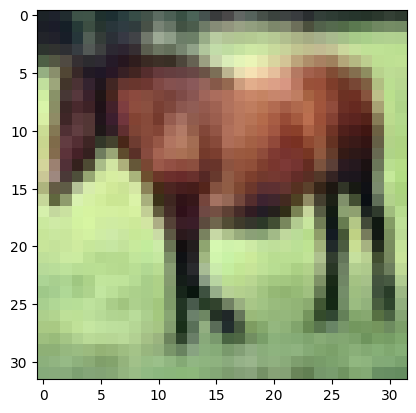

In [7]:
plt.imshow(trainset.data[7])
plt.show()

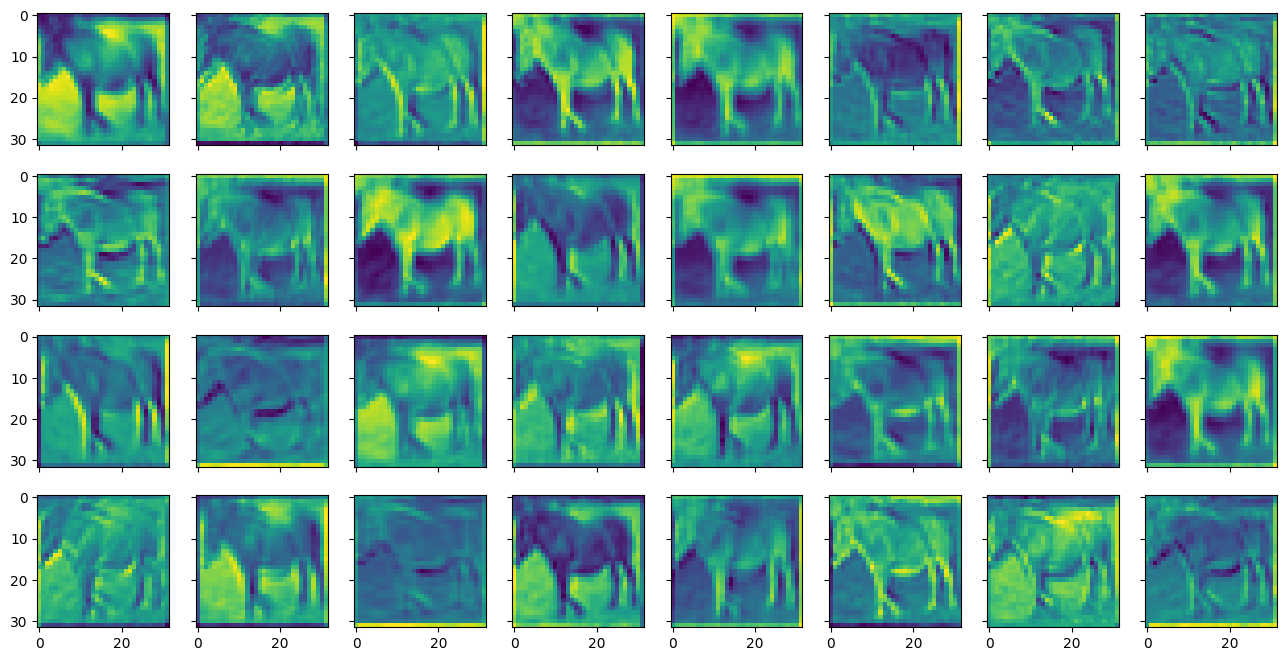

In [11]:
# Feature maps
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)


fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

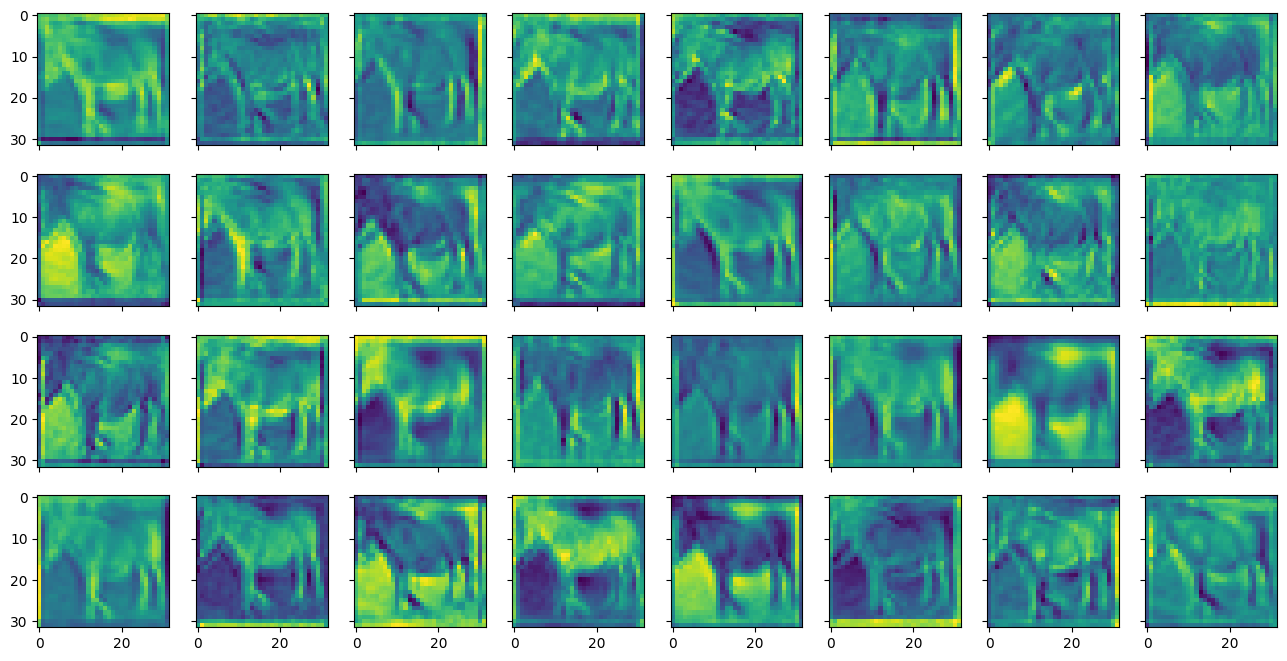

In [12]:
# Feature maps (a different way)
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)

model.eval()
with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))
    feature_maps = model.drop1(feature_maps)
    feature_maps = model.conv2(feature_maps)

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

**5)** How many layers do you need to get reasonable (80% or higher) accuracy with a model like this?  Can you do it with 2 layers?  If so, what activation functions etc. did you use?  Spend some time (but no more than a few hours) testing this out.  Report on how well different models do on this dataset.

In [15]:
class CIFAR100Model(nn.Module):
    def __init__(self):
        super(CIFAR100Model, self).__init__()
        # First convolutional layer with 64 filters
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Second convolutional layer with 128 filters
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.4)

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer for classification
        self.fc = nn.Linear(128, 100)  # 100 classes for CIFAR-100

    def forward(self, x):
        # First conv layer -> batch norm -> activation -> pool -> dropout
        x = self.drop1(self.pool1(self.act1(self.bn1(self.conv1(x)))))
        # Second conv layer -> batch norm -> activation -> pool -> dropout
        x = self.drop2(self.pool2(self.act2(self.bn2(self.conv2(x)))))
        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the output from GAP
        # Fully connected layer
        x = self.fc(x)
        return x

model = CIFAR100Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 0: model accuracy 37.14%
Epoch 1: model accuracy 42.89%
Epoch 2: model accuracy 45.93%
Epoch 3: model accuracy 46.56%
Epoch 4: model accuracy 48.71%
Epoch 5: model accuracy 49.74%
Epoch 6: model accuracy 50.63%
Epoch 7: model accuracy 51.31%
Epoch 8: model accuracy 52.99%
Epoch 9: model accuracy 53.16%
Epoch 10: model accuracy 54.08%
Epoch 11: model accuracy 54.77%
Epoch 12: model accuracy 54.58%
Epoch 13: model accuracy 55.26%
Epoch 14: model accuracy 55.67%
Epoch 15: model accuracy 55.85%
Epoch 16: model accuracy 54.40%
Epoch 17: model accuracy 56.78%
Epoch 18: model accuracy 57.33%
Epoch 19: model accuracy 57.74%


I created a two layer model above. This time, I tried to improve the accuracy by increasing the number of channels and then pooling it all together before passing them into a linear layer. I choose to keep the same activation function (relu). Unfortunately, I made a mistake and thought that there were 100 classes instead of 10. So this test may not be as accurate as I would have liked. It was like 20-25% less accurate than desired.

In [18]:
class ModifiedCIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        # First convolutional layer with 64 filters
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Second convolutional layer with 128 filters
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.4)

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer for classification
        self.fc = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # First conv layer -> batch norm -> activation -> pool -> dropout
        x = self.drop1(self.pool1(self.act1(self.bn1(self.conv1(x)))))
        # Second conv layer -> batch norm -> activation -> pool -> dropout
        x = self.drop2(self.pool2(self.act2(self.bn2(self.conv2(x)))))
        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the output from GAP
        # Fully connected layer
        x = self.fc(x)
        return x

model = ModifiedCIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 0: model accuracy 38.41%
Epoch 1: model accuracy 41.00%
Epoch 2: model accuracy 45.43%
Epoch 3: model accuracy 46.35%
Epoch 4: model accuracy 47.93%
Epoch 5: model accuracy 50.00%
Epoch 6: model accuracy 51.47%
Epoch 7: model accuracy 49.90%
Epoch 8: model accuracy 52.09%
Epoch 9: model accuracy 51.24%
Epoch 10: model accuracy 54.22%
Epoch 11: model accuracy 54.16%
Epoch 12: model accuracy 54.89%
Epoch 13: model accuracy 55.65%
Epoch 14: model accuracy 55.64%
Epoch 15: model accuracy 55.87%
Epoch 16: model accuracy 57.12%
Epoch 17: model accuracy 57.18%
Epoch 18: model accuracy 58.00%


This also ended with: "Epoch 19: model accuracy 57.27%" (though it didn't save). This time I fixed the error by going back to 10 classes. Also, I switched the Relu with Leaky Relu to incentivze the modle to be more confident in its predictions. Unfortunately, this model did much worse than I had expected, onlt getting an accuracy of 58%. So, it isn't really worth considering much more of its implementation.

In [5]:
# Image classification on CIFAR10

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class Modified2CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(48, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.GELU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = Modified2CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 0: model accuracy 35.51%
Epoch 1: model accuracy 42.23%
Epoch 2: model accuracy 44.77%
Epoch 3: model accuracy 47.72%
Epoch 4: model accuracy 51.03%
Epoch 5: model accuracy 53.17%
Epoch 6: model accuracy 55.15%
Epoch 7: model accuracy 57.57%
Epoch 8: model accuracy 59.19%
Epoch 9: model accuracy 61.01%
Epoch 10: model accuracy 62.97%
Epoch 11: model accuracy 65.07%
Epoch 12: model accuracy 67.05%
Epoch 13: model accuracy 68.81%
Epoch 14: model accuracy 70.40%
Epoch 15: model accuracy 71.68%
Epoch 16: model accuracy 73.24%
Epoch 17: model accuracy 74.04%
Epoch 18: model accuracy 75.87%
Epoch 19: model accuracy 76.91%


This model worked the best of all of them. I went back to the original code we had and eddited it by just adding more channels, using LeakyRelu on the first layer, and just Relu on the second. This model worked the best, showing that its simplicity may be beneficial. Also, it proves that if we limit the number of convolutional layers, it is beneficial to increase the number of channels. This gives the model more freedom to find the optimal function.

After these three experiments, I had already spent 3 hours training the models. So, I am going to stop here. But, looking at the last model, it appears that it may hit the 80% accuracy mark if it was trained for a few more epochs. But, that would take another hour and a half. I may also be able to reach this number by further increasing the number of channels in each layer.